In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [7]:
df=pd.read_csv('credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Columns: ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']

--- Preprocessing ---
--- Training Model ---
Model AUC Score: 0.8684

--- Optimizing Decision Threshold ---
Optimal Threshold: 0.25
Minimum Total Cost: $5,018,000


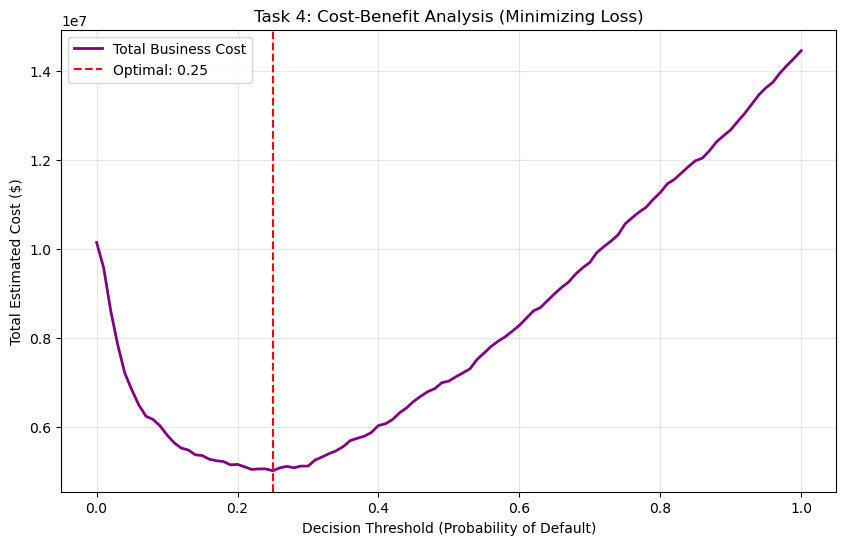


--- Strategy Recommendation ---
Standard Threshold (0.50) Cost: $7,032,000
Optimized Threshold (0.25) Cost: $5,018,000
Recommendation: Reject loan applications if the predicted Risk Score is higher than 0.25.


In [9]:
# Display column names to verify
print("Columns:", df.columns.tolist())

# ==========================================
# 2. Data Cleaning & Preprocessing
# ==========================================
print("\n--- Preprocessing ---")

# Define features and target
# Based on your data, 'loan_status' is the target (1 = Default, 0 = Non-Default)
target_col = 'loan_status'
X = df.drop(columns=[target_col])
y = df[target_col]

# Identify Numerical and Categorical columns
# We explicitly list them based on your snippet to ensure accuracy
numeric_features = [
    'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'
]
categorical_features = [
    'person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'
]

# Check if 'person_age' exists (it was in your data rows but maybe not header)
# If missing from dataframe, remove it from the list
numeric_features = [col for col in numeric_features if col in X.columns]

# --- Build a Preprocessing Pipeline ---
# 1. Numeric: Fill missing values with Median + Scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical: Fill missing with 'Missing' + One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine them
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# 3. Train Model (Logistic Regression)
# ==========================================
print("--- Training Model ---")

# Pipeline: Preprocess -> Train
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

model.fit(X_train, y_train)

# Get Probabilities (Risk Scores)
y_prob = model.predict_proba(X_test)[:, 1]

print(f"Model AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# ==========================================
# 4. Business Cost Optimization
# ==========================================
print("\n--- Optimizing Decision Threshold ---")

# Define Business Costs
# Scenario:
# - False Negative (FN): We lend, they default. LOSS = $10,000 (Principal lost)
# - False Positive (FP): We reject, they would've paid. LOSS = $2,000 (Interest lost)
COST_FN = 10000 
COST_FP = 2000  

thresholds = np.linspace(0, 1, 101)
costs = []

for t in thresholds:
    # If probability > t, predict Default (1)
    preds = (y_prob >= t).astype(int)
    
    # Calculate counts
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    # Total Cost Calculation
    # Note: In 'loan_status', 1 is Default.
    # FN here means: Model predicted 0 (No Default), but Truth was 1 (Default).
    total_cost = (fn * COST_FN) + (fp * COST_FP)
    costs.append(total_cost)

# Find optimal
optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = costs[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Minimum Total Cost: ${min_cost:,.0f}")

# ==========================================
# 5. Visualization
# ==========================================
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, color='purple', linewidth=2, label='Total Business Cost')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal: {optimal_threshold:.2f}')

plt.title('Task 4: Cost-Benefit Analysis (Minimizing Loss)')
plt.xlabel('Decision Threshold (Probability of Default)')
plt.ylabel('Total Estimated Cost ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Final Strategy Output
print("\n--- Strategy Recommendation ---")
print(f"Standard Threshold (0.50) Cost: ${costs[50]:,.0f}")
print(f"Optimized Threshold ({optimal_threshold:.2f}) Cost: ${min_cost:,.0f}")
print(f"Recommendation: Reject loan applications if the predicted Risk Score is higher than {optimal_threshold:.2f}.")